In [1]:
%matplotlib inline

In [28]:
from scipy import signal
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis.resonator import plot_resonator
from kid_readout.roach import demodulator

In [3]:
npd = npy.NumpyDirectory('/data/detectors/2016-12-09_113712_sweep_stream_on_off_wideband/')

In [4]:
all_sss = [npd.read(name) for name in npd.node_names() if name.startswith('SingleSweepStream')]
all_snap = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

In [18]:
[(snap.x.ptp(), snap.y.ptp()) for snap in all_snap]

[(164.0, 170.0), (61.0, 65.0)]

In [5]:
num_channels = 1
sss_dict = {}
for channel in range(num_channels):
    sss_dict[channel] = [sss for sss in all_sss if sss.state.lo_index == channel]

In [6]:
bin(all_sss[0].stream.roach_state.fft_shift_register)

'0b11111111111111111000'

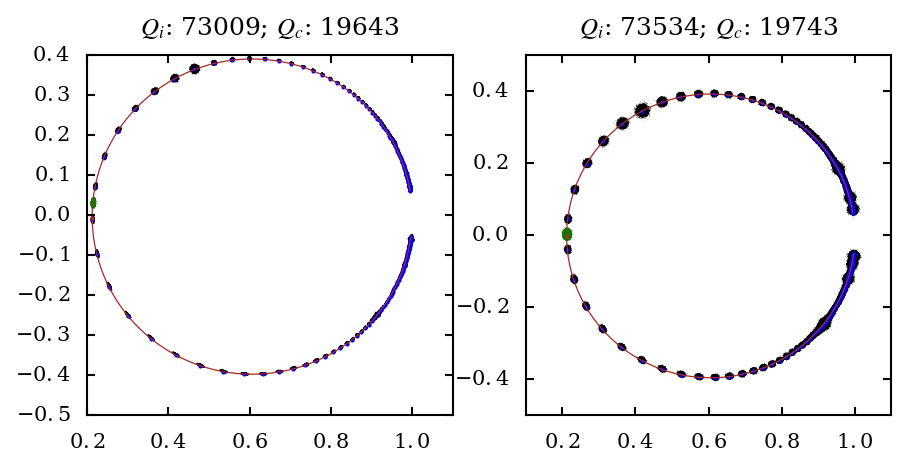

In [7]:
channel = 0
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
for sss, ax in zip(sss_dict[channel], axes.flatten()):
    plot_basic.sss_complex_plane(sss, ax)
    ax.set_title("$Q_i$: {:.0f}; $Q_c$: {:.0f}".format(sss.resonator.Q_i, sss.resonator.Q_e_real), fontsize=6)
    ax.tick_params(labelsize=5)

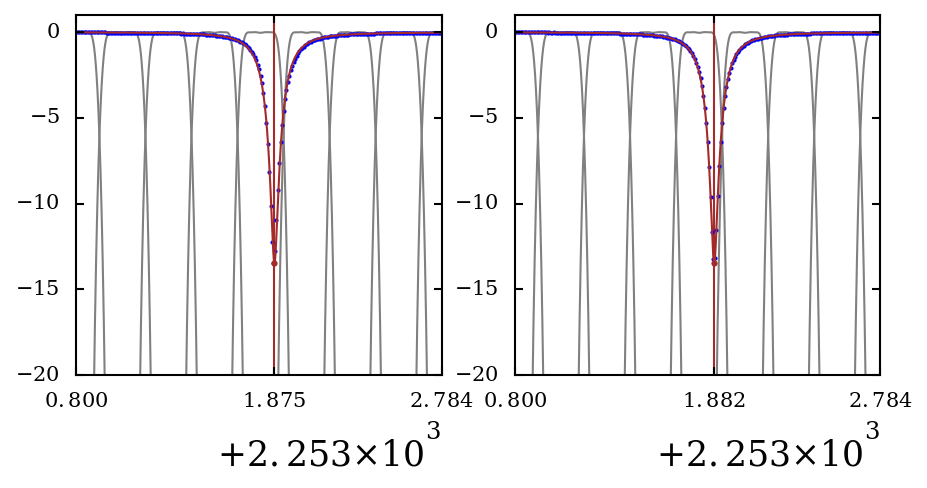

In [32]:
f_scale = 1e-6
channel = 0
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
for sss, ax in zip(sss_dict[channel], axes.flatten()):
    demod = demodulator.Demodulator(nfft=sss.stream.roach_state.num_filterbank_channels, num_taps=8,
                                    window=signal.hamming, hardware_delay_samples=0)
    for filterbank_bin in np.unique([stream.filterbank_bin for stream in sss.sweep.streams]):
        f_filterbank = (sss.stream.roach_state.adc_sample_rate * filterbank_bin /
                        sss.stream.roach_state.num_filterbank_channels)
        ax.plot(f_scale * (sss.stream.roach_state.lo_frequency + f_filterbank + 
                           sss.stream.stream_sample_rate * demod._window_frequency),
                20 * np.log10(demod._window_response),
                '-', color='gray')
    ax.axvline(f_scale * sss.resonator.f_0, color='brown')
    plot_resonator.amplitude(ax, sss.resonator, f_scale=f_scale, normalize=True)
    ax.set_xlim(f_scale * sss.sweep.streams[0].frequency, f_scale * sss.sweep.streams[-1].frequency)
    ax.set_ylim(-20, 1)
    ax.tick_params(labelsize=5)

In [29]:
def plot_noise(sss):
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency / Hz')
    ax.set_ylabel('$S \; / \; \mathrm{Hz}^{-1}$')
    ax.plot(sss.S_frequency, sss.S_xx, '-b', label='$S_{xx}$')
    ax.plot(sss.S_frequency, sss.S_yy, '-g', label='$S_{yy}$')
    return fig, ax

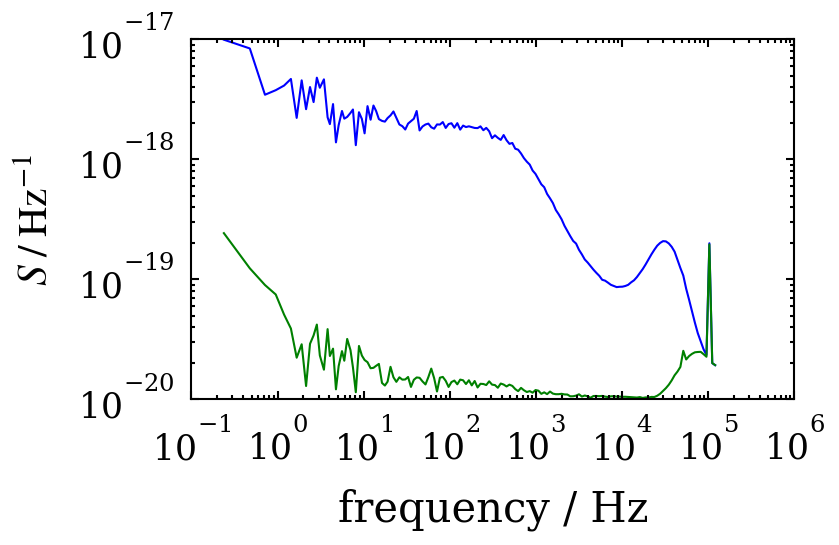

In [14]:
fig, ax = plot_noise(all_sss[0])

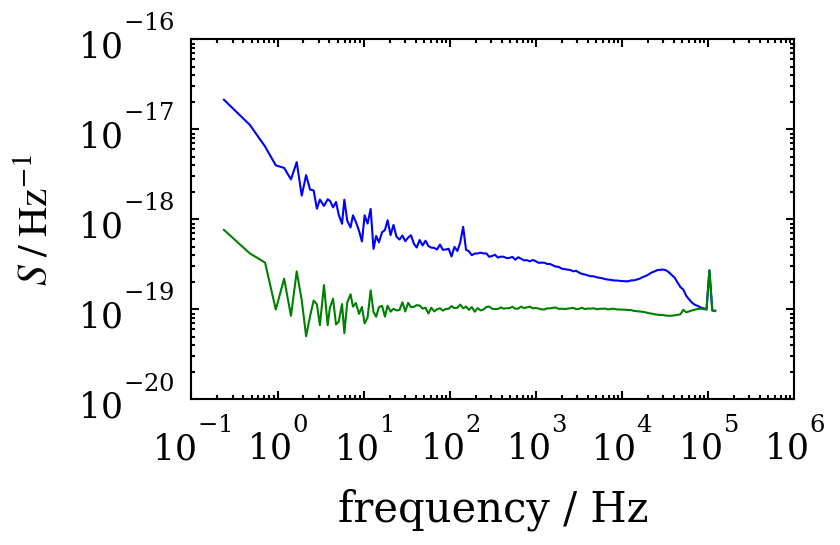

In [15]:
fig, ax = plot_noise(all_sss[1])